In [1]:
import scanpy as sc
import scarches as sca
import pandas as pd
import numpy as np
from scarches.dataset.trvae.data_handling import remove_sparsity

In [2]:
# path_data='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/'
# path_save=path_data+'integrated/gsCellType_query/'
# path_gmt='/storage/groups/ml01/code/karin.hrovatin//qtr_intercode_reproducibility-/metadata/'

In [3]:
path_data='./'
path_save=path_data+'integrated/gsCellType_query/'
path_gmt='../metadata/'

## Prepare ref and query

In [4]:
# Load data
adata=sc.read(path_data+'adata_annotated.h5ad')
adata.shape

(137964, 13520)

In [5]:
ct_query='immune' # Cell types containing this word are removed from reference (but not query)
study_query='STZ' # remove this study from reference and use as query
adata.obs['ref_query']=['ref' if study!=study_query else 'query'
                           for study in adata.obs.study]

In [6]:
# +
# Ref
# Subset to all but query study
adata_r=adata.raw.to_adata()[adata.obs.study!=study_query,:]
adata_r.obs['cell_type']=adata[adata_r.obs_names,:].obs.cell_type
print('Ref shape:',adata_r.shape)
# Ductal cells and ductal dublets not included in ref
adata_r=adata_r[~adata_r.obs.cell_type.str.contains(ct_query),:]
# Remove genes expressed in < 20 cells in ref
adata_r=adata_r[:,(adata_r.X!=0).sum(axis=0)>=20].copy()

# Remove top ambient genes
# if args.remove_ambient:
#     ambient=pd.read_table(path_data+'ambient_genes_scores.tsv',index_col=0)
#     ambient=set(ambient[(ambient>0.005).any(axis=1)].index)
#     adata_r=adata_r[:,[g for g in adata_r.var_names if g not in ambient]]

# Compute HVG across batches
use_hvg = False
if  use_hvg:
    # Normalise data for HVG computation
    adata_r_norm=adata_r.copy()
    sc.pp.normalize_total(adata_r_norm, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata_r_norm)
    # HVG compute and subset
    adata_r=adata_r[:,sc.pp.highly_variable_genes(
        adata_r_norm, flavor='cell_ranger',n_top_genes=10000,
        batch_key="study",subset=False, inplace=False)['highly_variable']].copy()
    del adata_r_norm

print('Ref filtered shape:',adata_r.shape)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


Ref shape: (101065, 30672)
Ref filtered shape: (96314, 19719)


In [7]:
# Add gene set anno to ref
# Omit gene sets not having at least 5 genes
sca.add_annotations(adata_r, 
                    [path_gmt+'PanglaoDB_markers_27_Mar_2020_mouseEID.gmt',
                    path_gmt+'c2.cp.reactome.v4.0_mouseEID.gmt'], 
                    min_genes=3, clean=False)
print('N used gene sets:',adata_r.varm['I'].shape[1])

# Subset data to only genes in added gene sets
adata_r=adata_r[:,adata_r.varm['I'].sum(axis=1)>0].copy()
print('N retained genes',adata_r.shape[1])

N used gene sets: 838
N retained genes 6906


In [8]:
# Query data - subset to query study cells and ref genes
adata_q=adata.raw.to_adata()[adata.obs.study==study_query,adata_r.var_names]
adata_q.obs['cell_type']=adata[adata_q.obs_names,:].obs.cell_type
print('Query shape:',adata_q.shape)

Trying to set attribute `.obs` of view, copying.


Query shape: (36899, 6906)


In [9]:
# Query batches
print('Query batches:',adata_q.obs.study_sample.unique().to_list())

Query batches: ['STZ_G2', 'STZ_G8', 'STZ_G5', 'STZ_G1', 'STZ_G6', 'STZ_G4', 'STZ_G3']


In [10]:
adata_r.obs.study.value_counts()

NOD_elimination    51136
spikein_drug       22026
Fltp_P16           20443
NOD                 2709
Name: study, dtype: int64

## Training

In [11]:
# Use whole datasets or only subset for testing out the scripts
testing=False
def subset_data(adata,proportion=0.05):
    np.random.seed(0)
    random_indices=np.random.permutation(list(range(adata.shape[0]))
                                        )[:int(adata.shape[0]*proportion)]
    return adata[random_indices,:].copy()
if testing:
    adata_r_sub=subset_data(adata_r)
    adata_q_sub=subset_data(adata_q)
    adata_sub=subset_data(adata)
else:
    adata_r_sub=adata_r.copy()
    adata_q_sub=adata_q.copy()
    adata_sub=adata.copy()
adata_sub=adata_sub.raw.to_adata()[:,adata_r_sub.var_names]
print('Ref:',adata_r_sub.shape,'Query:',adata_q_sub.shape,'All:',adata_sub.shape)
# Ref: (109639, 6918) Query: (24275, 6918) All: (137964, 6918)

Ref: (96314, 6906) Query: (36899, 6906) All: (137964, 6906)


In [12]:
# Save data for other integration methods
# Subset only to query and ref, not all cells
if False:
    adata_integration=adata_sub[adata_r_sub.obs_names.to_list()+\
                                adata_q_sub.obs_names.to_list(),:].copy()
    # Query-ref info
    adata_integration.obs.loc[adata_r_sub.obs_names,'ref_query']='ref'
    adata_integration.obs.loc[adata_q_sub.obs_names,'ref_query']='query'
    # Save
    print('Integration data shape:',adata_integration.shape)
    adata_integration.write(path_data+'integrated/gsCellType_query/model/adata_integration_RefQueryTraining.h5ad')
    del adata_integration
    # Integration data shape: (133914, 6918)

In [13]:
path_data+'integrated/gsCellType_query/model/adata_integration_RefQueryTraining.h5ad'

'./integrated/gsCellType_query/model/adata_integration_RefQueryTraining.h5ad'

### Create the model and train it on reference dataset

In [53]:
ALPHA = 0.7
EPOCHS = 400
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [77]:
adata_r_sub = adata_r_sub[adata_r_sub.obs.study!= "NOD_elimination"]

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [78]:
model = sca.models.TRVAE(
    adata=remove_sparsity(adata_r_sub),
    condition_key='study_sample',
    hidden_layer_sizes=[838, 838,838],
    use_mmd=False,
    recon_loss='nb',
    mask=adata_r.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
    ,decoder_last_layer="softplus")


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 6906 838 21
	Hidden Layer 1 in/out: 838 838
	Hidden Layer 2 in/out: 838 838
	Mean/Var Layer in/out: 838 838
Decoder Architecture:
	Masked linear layer in, out and cond:  838 6906 21


In [79]:
ALPHA = 0.7
EPOCHS = 500
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

# model.train(
#     n_epochs=EPOCHS, 
#     alpha_epoch_anneal=100, 
#     alpha=None, 
#     omega=None,
#     alpha_kl=0.5,
#     weight_decay=0., 
#     early_stopping_kwargs=early_stopping_kwargs,
#     use_early_stopping=True,
#     seed=2020)

model.train(
    n_epochs=EPOCHS, 
    alpha_epoch_anneal=100, 
    alpha=None, 
    omega=None,
    alpha_kl=0.1,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███████-------------| 39.4%  - epoch_loss: 3492.94 - epoch_recon_loss: 3400.18 - epoch_kl_loss:  927.57 - val_loss: 3357.42 - val_recon_loss: 3271.02 - val_kl_loss:  864.04526
ADJUSTED LR
 |█████████-----------| 45.4%  - epoch_loss: 3477.97 - epoch_recon_loss: 3384.94 - epoch_kl_loss:  930.24 - val_loss: 3357.50 - val_recon_loss: 3271.25 - val_kl_loss:  862.53
ADJUSTED LR
 |█████████-----------| 46.8%  - epoch_loss: 3483.03 - epoch_recon_loss: 3389.99 - epoch_kl_loss:  930.42 - val_loss: 3356.49 - val_recon_loss: 3270.12 - val_kl_loss:  863.78
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 212


In [80]:
# Mark inactivated terms
adata_r_sub.uns['terms_is_active'] = \
    (model.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
print([term for i, term in enumerate(adata_r_sub.uns['terms']) 
       if not adata_r_sub.uns['terms_is_active'][i]])

Trying to set attribute `.uns` of view, copying.


Inactive terms:
[]


In [82]:
# Add integrated embedding
adata_r_sub.obsm['X_integrated'] = model.get_latent(mean=True)[:, adata_r_sub.uns['terms_is_active']]

In [ ]:
# adata_r_sub_ss = sc.pp.subsample(adata_r_sub, copy=True, fraction=0.2)

In [83]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_r_sub, use_rep='X_integrated')
sc.tl.umap(adata_r_sub)

... storing 'ref_query' as categorical


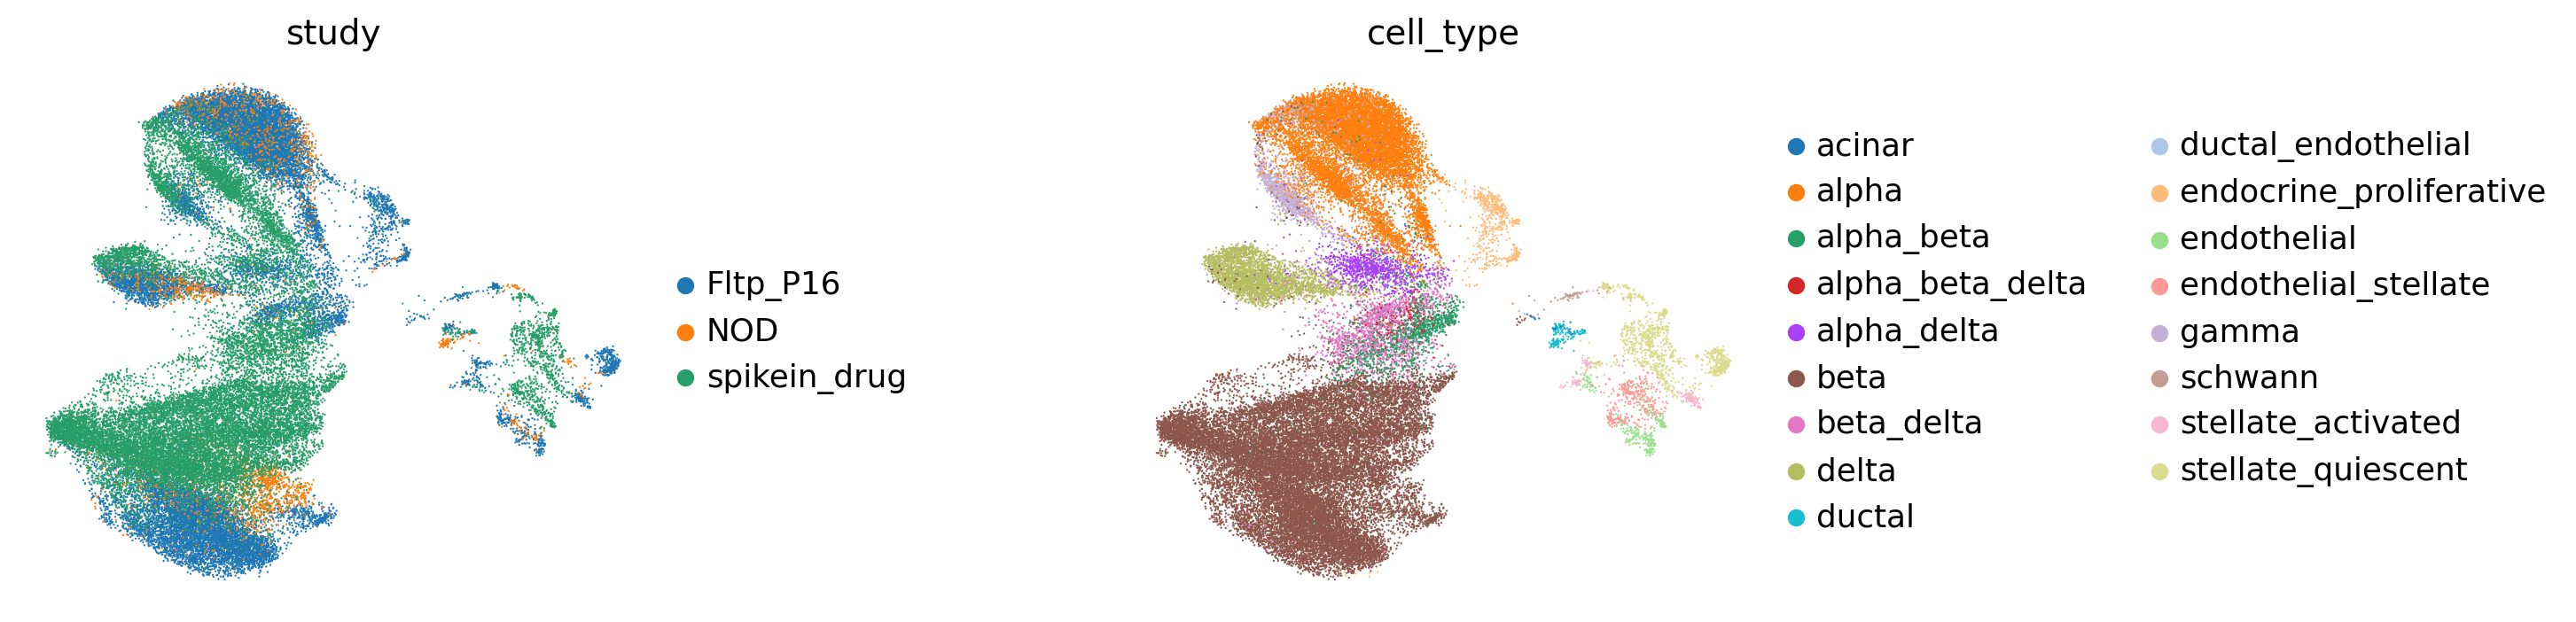

In [84]:
# Plot integrated UMAP
sc.pl.umap(adata_r_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

In [85]:
name = "reference_panc_s"

In [86]:
model.save(name)

### Add query

In [87]:
# Make query model from original model
model_q = sca.models.TRVAE.load_query_data(remove_sparsity(adata_q_sub), model)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 6906 838 28
	Hidden Layer 1 in/out: 838 838
	Hidden Layer 2 in/out: 838 838
	Mean/Var Layer in/out: 838 838
Decoder Architecture:
	Masked linear layer in, out and cond:  838 6906 28


In [88]:
# Train query model
model_q.train(
    n_epochs=400,
    alpha_epoch_anneal=None,  
    alpha_kl=0.45, 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    weight_decay=0,
    alpha=None, 

    seed=0
)

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - epoch_loss: 3442.35 - epoch_recon_loss: 3144.08 - epoch_kl_loss:  662.82 - val_loss: 3434.55 - val_recon_loss: 3137.03 - val_kl_loss:  661.16
Saving best state of network...
Best State was in Epoch 397


In [92]:
adata_rq = sc.concat([adata_q_sub, adata_r_sub])

In [95]:
# Prediction 
adata_rq.obsm['X_integrated'] = model_q.get_latent(
    remove_sparsity( adata_rq[:,adata_rq.var_names]).X, 
    adata_rq.obs['study_sample'], mean=True
    )[:, adata_r_sub.uns['terms_is_active']]

In [96]:
# Add term info
adata_rq.uns['terms_is_active']=adata_r_sub.uns['terms_is_active'].copy()
adata_rq.uns['terms']=adata_r_sub.uns['terms'].copy()

In [97]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_rq, use_rep='X_integrated')
sc.tl.umap(adata_rq)

... storing 'leiden_r1_normscl' as categorical
... storing 'design' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'sample' as categorical
... storing 'study' as categorical
... storing 'study_sample' as categorical
... storing 'cell_type' as categorical
... storing 'ref_query' as categorical


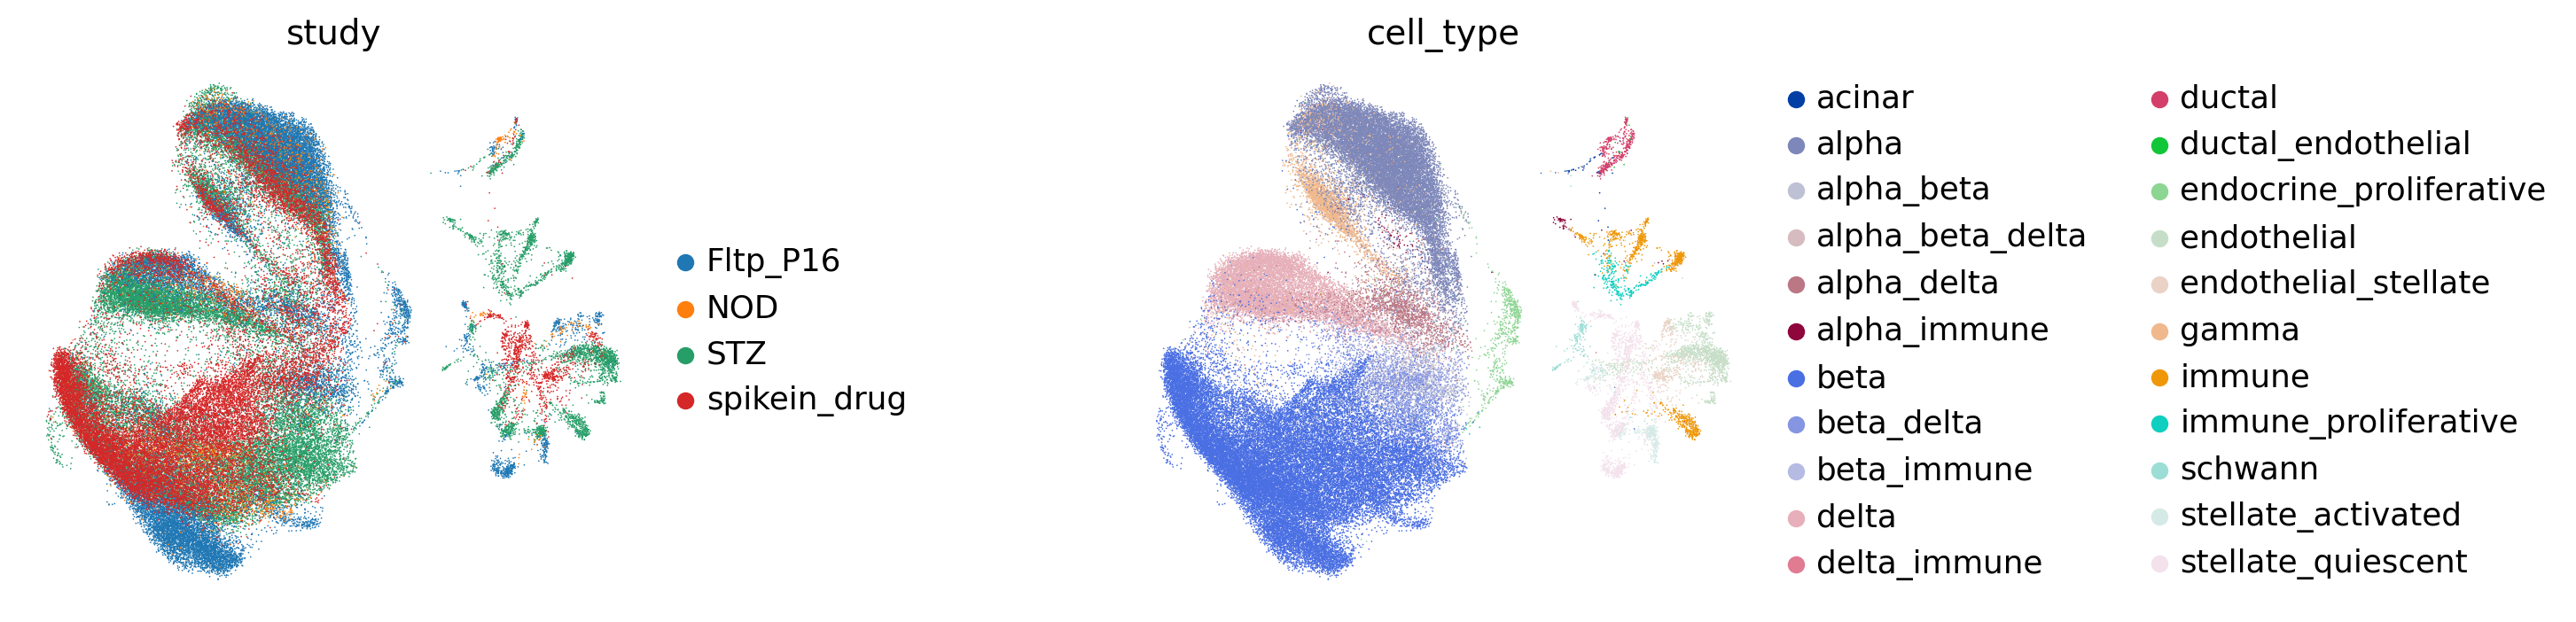

In [98]:
# Plot integrated embedding
sc.pl.umap(adata_rq, color=['study', 'cell_type'], frameon=False, wspace=0.6)

## Save

In [99]:
# Save model
if not testing:
    model.save(path_save)

In [124]:
# Save
if testing:
    adata_sub.write(path_data+'data_integrated_try.h5ad')
else:
    adata_sub.write(path_save+'data_integrated.h5ad')

In [29]:
path_save+'data_integrated.h5ad'

'/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/data_integrated_try.h5ad'